#Initialization

In [ ]:
#https://github.com/davide-coccomini/TimeSformer-Video-Classification/blob/main/main.ipynb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
BASE_DIR = '/content/drive/My Drive/'
DATA_DIR = BASE_DIR + "data/"
FRAMES_INTERVAL = 10

In [ ]:
pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torch import nn, einsum
import torch.nn.functional as F
from einops import rearrange, repeat


#TimeSformer


##Attention

The attentation is represented using **Query-Key-Value**

---

representation (QKV). It is like searching a Query, discover that

---

this query is related with a specific Key and then return the

---

Value associated with that key.

---



**Single-Head attention**

$Attention(Q, K, V) = Softmax(\frac{QK^T}{\sqrt{d_k}})*V$

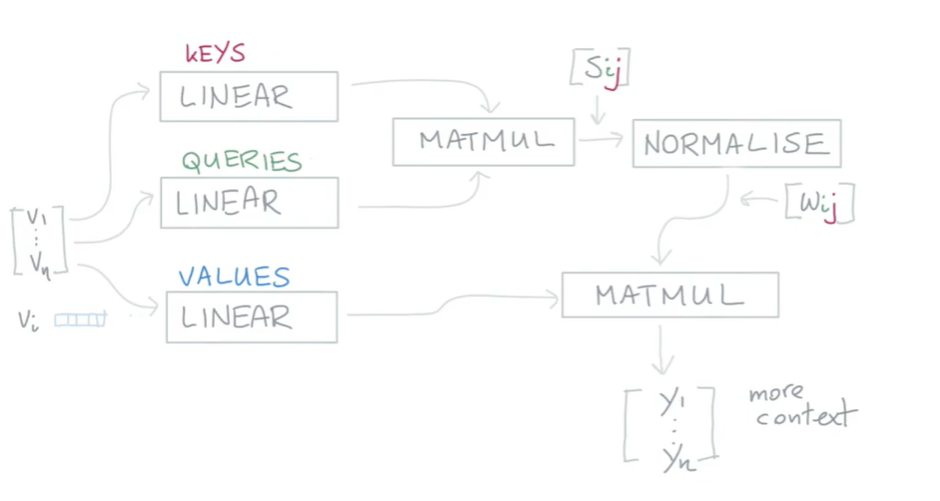


**Multi-Head attention**

$MultiHead(Q, K, V) = Concat(head_1, ..., head_h)*W^O$
where $head_i = Attention(Q{W_i}^Q, K{W_i}^K, V{W_i}^V)$

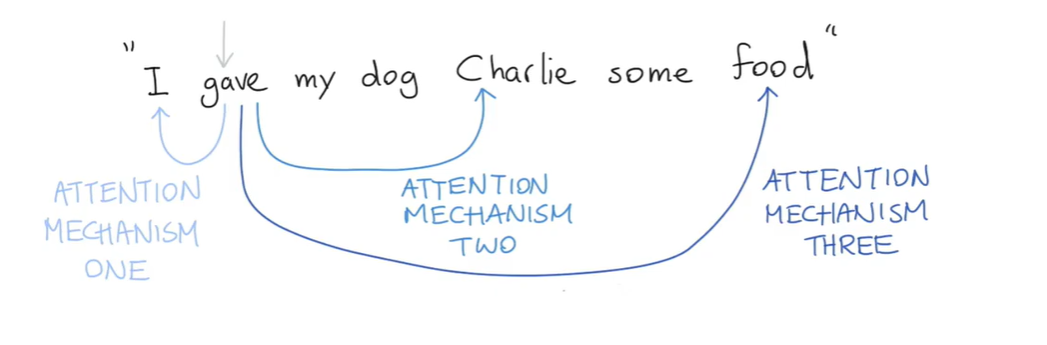

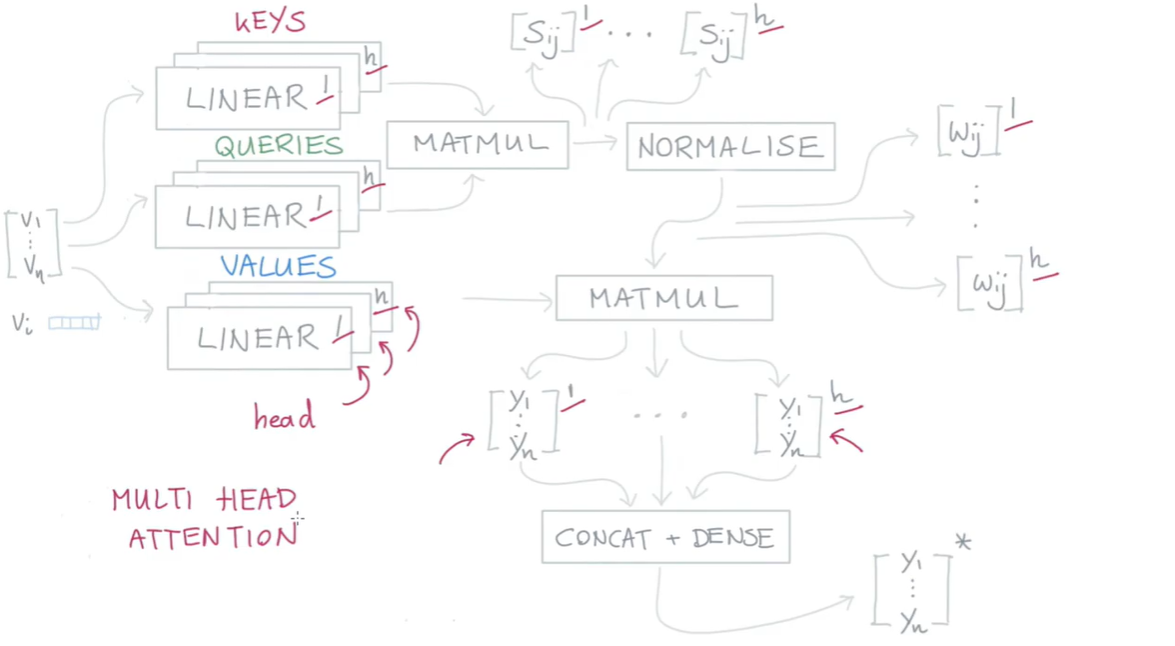


##Normalization

To calculate the Q,K,V vectors a normalization layer is needed.

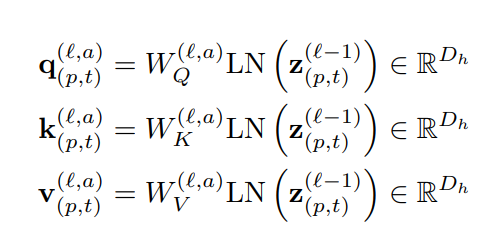

In [ ]:
from google.colab.patches import cv2_imshow
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)

    def forward(self, x, *args, **kwargs):
        x = self.norm(x)
        return self.fn(x, *args, **kwargs)

## Feed Forward

In [ ]:
class GEGLU(nn.Module):
    def forward(self, x):
        x, gates = x.chunk(2, dim = -1)
        return x * F.gelu(gates)

class FeedForward(nn.Module):
    def __init__(self, dim, mult = 4, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim * mult * 2),
            GEGLU(),
            nn.Dropout(dropout),
            nn.Linear(dim * mult, dim)
        )

    def forward(self, x):
        return self.net(x)

## Divided Space-Time Attention

Self-attention weights are computed via dot-product. The self-attention weights for query patch (p, t) are given by:
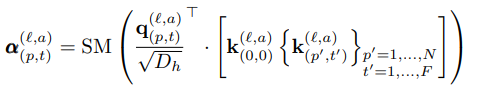

where SM denotes the softmax activation function.

In order to reduce computational cost we replace the spatiotemporal attention with spatial attention within each frame only. However, such a model neglects to capture temporal dependencies across frames.
A more efficient architecture for spatiotemporal attention is **Divided Space-Time Attention** (T+S), where temporal attention and spatial attention are separateli applied one after the other.

Within each blocl $l$, we first compute temporal attention by comparing each patch $(p, t)$ with all the patches at the same spatial location in other frames:

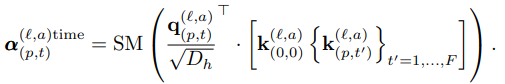

The resulting encoding, obtained using temporal attention, is then fed back for spatial attention computation instead of beign passed to the MLP. In other wordsd, new key/query/value vectors are obtained and spatial attention is then computed using:

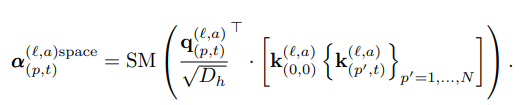

In [ ]:
# attention

def attn(q, k, v):
    sim = einsum('b i d, b j d -> b i j', q, k)
    attn = sim.softmax(dim = -1)
    out = einsum('b i j, b j d -> b i d', attn, v)
    return out

class Attention(nn.Module):
    def __init__(
        self,
        dim,
        dim_head = 64,
        heads = 8,
        dropout = 0.
    ):
        super().__init__()
        self.heads = heads
        self.scale = dim_head ** -0.5
        inner_dim = dim_head * heads

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)
        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x, einops_from, einops_to, **einops_dims):
        h = self.heads
        q, k, v = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> (b h) n d', h = h), (q, k, v))

        q *= self.scale

        # splice out classification token at index 1
        (cls_q, q_), (cls_k, k_), (cls_v, v_) = map(lambda t: (t[:, 0:1], t[:, 1:]), (q, k, v))

        # let classification token attend to key / values of all patches across time and space
        cls_out = attn(cls_q, k, v)

        # rearrange across time or space
        q_, k_, v_ = map(lambda t: rearrange(t, f'{einops_from} -> {einops_to}', **einops_dims), (q_, k_, v_))

        # expand cls token keys and values across time or space and concat
        r = q_.shape[0] // cls_k.shape[0]
        cls_k, cls_v = map(lambda t: repeat(t, 'b () d -> (b r) () d', r = r), (cls_k, cls_v))

        k_ = torch.cat((cls_k, k_), dim = 1)
        v_ = torch.cat((cls_v, v_), dim = 1)

        # attention
        out = attn(q_, k_, v_)

        # merge back time or space
        out = rearrange(out, f'{einops_to} -> {einops_from}', **einops_dims)

        # concat back the cls token
        out = torch.cat((cls_out, out), dim = 1)

        # merge back the heads
        out = rearrange(out, '(b h) n d -> b n (h d)', h = h)

        # combine heads out
        return self.to_out(out)


In [ ]:
# main classes
class TimeSformer(nn.Module):
    def __init__(
        self,
        *,
        dim,
        num_frames,
        num_classes,
        image_size = 224,
        patch_size = 16,
        channels = 3,
        depth = 12,
        heads = 8,
        dim_head = 64,
        attn_dropout = 0.,
        ff_dropout = 0.
    ):
        super().__init__()
        assert image_size % patch_size == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_size // patch_size) ** 2
        num_positions = num_frames * num_patches
        patch_dim = channels * patch_size ** 2

        self.patch_size = patch_size
        self.to_patch_embedding = nn.Linear(patch_dim, dim)
        self.pos_emb = nn.Embedding(num_positions + 1, dim)
        self.cls_token = nn.Parameter(torch.randn(1, dim))

        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, dim_head = dim_head, heads = heads, dropout = attn_dropout)), # Time attention
                PreNorm(dim, Attention(dim, dim_head = dim_head, heads = heads, dropout = attn_dropout)), # Spatial attention
                PreNorm(dim, FeedForward(dim, dropout = ff_dropout)) # Feed Forward
            ]))

        self.to_out = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, video):
        b, f, _, h, w, *_, device, p = *video.shape, video.device, self.patch_size
        assert h % p == 0 and w % p == 0, f'height {h} and width {w} of video must be divisible by the patch size {p}'

        n = (h // p) * (w // p)
        video = rearrange(video, 'b f c (h p1) (w p2) -> b (f h w) (p1 p2 c)', p1 = p, p2 = p)

        tokens = self.to_patch_embedding(video)

        cls_token = repeat(self.cls_token, 'n d -> b n d', b = b)
        x =  torch.cat((cls_token, tokens), dim = 1)
        x += self.pos_emb(torch.arange(x.shape[1], device = device))

        for (time_attn, spatial_attn, ff) in self.layers:
            x = time_attn(x, 'b (f n) d', '(b n) f d', n = n) + x
            x = spatial_attn(x, 'b (f n) d', '(b f) n d', f = f) + x
            x = ff(x) + x

        cls_token = x[:, 0]

        return self.to_out(cls_token)

#Execution

In [ ]:
import torch
import cv2
import numpy as np
import os
import math
import torch.optim as optim

preview = []
videos = []

# GET MIN VIDEO FRAME PER VIDEO: Videos may have different shapes
min_video_frames = math.inf

for video_file_name in os.listdir(DATA_DIR):
  vidcap  = cv2.VideoCapture(DATA_DIR + video_file_name)
  length = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
  if length < min_video_frames:
    min_video_frames = length


# EXTRACT SOME FRAMES FROM VIDEOS
for video_file_name in os.listdir(DATA_DIR):
  print("Loading " + video_file_name + "...")
  vidcap  = cv2.VideoCapture(DATA_DIR + video_file_name)
  success, image = vidcap.read()
  considered_frames_counter = 0
  frames = []
  while success:

    if considered_frames_counter == int(min_video_frames / FRAMES_INTERVAL) - 1:
      break

    success,image = vidcap.read()
    if considered_frames_counter == FRAMES_INTERVAL:
      preview.append((video_file_name, cv2.resize(image, (224,224))))
    if success and considered_frames_counter % FRAMES_INTERVAL == 0:
      image = np.transpose(np.asarray(cv2.resize(image, (224,224))), (2, 0, 1))
      frames.append(image)

    if success:
      considered_frames_counter += 1

  videos.append(frames)


video = torch.tensor(np.asarray(videos)).float() # (batch x frames x channels x height x width)

del videos



Loading waterfall.mov...
Loading nature.mov...
Loading rate.mov...
Loading slug.mov...
Loading lake.mov...
Loading river.mov...
Loading rabbit.mov...
Loading city.mov...
Loading dog2.mov...
Loading dog3.mov...
Loading city2.mov...
Loading chess.mov...
Loading slug2.mov...


#Training

In [ ]:
#Parameters
DIM = 224
IMAGE_SIZE = 224
PATCH_SIZE = 16
NUM_CLASSES = 2
NUM_FRAMES = 20
DEPTH = 12
HEADS = 8
DIM_HEAD = 64
ATTN_DROPOUT = 0.1
FF_DROPOUT = 0.1
ITERATIONS = 20

In [ ]:
model = torch.nn.Sequential(
    TimeSformer(dim = DIM, image_size = IMAGE_SIZE, patch_size = PATCH_SIZE, num_frames = NUM_FRAMES, num_classes = NUM_CLASSES, depth = DEPTH, heads = HEADS, dim_head = DIM_HEAD, attn_dropout = ATTN_DROPOUT, ff_dropout = FF_DROPOUT),
    nn.Softmax(dim=1)
)

loss_fn = torch.nn.MSELoss(reduction='sum')
labels = torch.FloatTensor([[0.4, 0.6] for i in range(len(video))]) # Add here your own labels

learning_rate = 1e-4
for t in range(ITERATIONS):
  y_pred = model(torch.FloatTensor(np.asarray(video)))

  loss = loss_fn(y_pred, torch.tensor(labels))
  print("#" + str(t), " loss:" + str(loss.item()))

  model.zero_grad()
  loss.backward()
  with torch.no_grad():
      for param in model.parameters():
          param -= learning_rate * param.grad

pred = model(video) # (batch x classes)


<ipython-input-12-4de8d87f333e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = loss_fn(y_pred, torch.tensor(labels))


#0  loss:0.9107568264007568
#1  loss:0.6017046570777893
#2  loss:0.18842825293540955
#3  loss:0.08493201434612274
#4  loss:0.13013212382793427
#5  loss:0.09467010945081711
#6  loss:0.14850257337093353
#7  loss:0.10444922745227814
#8  loss:0.05295591056346893
#9  loss:0.09243757277727127
#10  loss:0.05683181807398796
#11  loss:0.08576714247465134
#12  loss:0.13129112124443054
#13  loss:0.06621740013360977
#14  loss:0.08025285601615906
#15  loss:0.0734914168715477
#16  loss:0.08147139102220535
#17  loss:0.07720337808132172
#18  loss:0.04081622511148453
#19  loss:0.07124010473489761


#Evaluation

In [ ]:
a

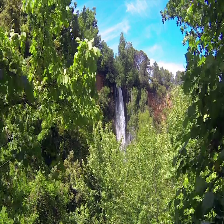

waterfall.mov
tensor([0.4493, 0.5507], grad_fn=<UnbindBackward0>)
________________________________________________


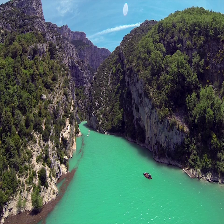

nature.mov
tensor([0.4798, 0.5202], grad_fn=<UnbindBackward0>)
________________________________________________


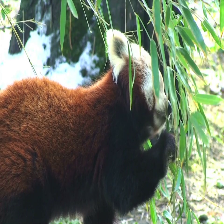

rate.mov
tensor([0.4079, 0.5921], grad_fn=<UnbindBackward0>)
________________________________________________


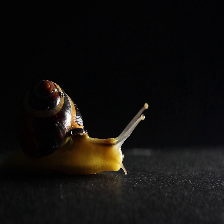

slug.mov
tensor([0.3805, 0.6195], grad_fn=<UnbindBackward0>)
________________________________________________


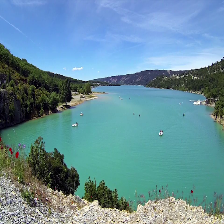

lake.mov
tensor([0.4469, 0.5531], grad_fn=<UnbindBackward0>)
________________________________________________


In [ ]:
for index, prediction in enumerate(pred):
  considered_video = preview[index]
  cv2_imshow(considered_video[1])
  print(considered_video[0])
  print(prediction)
  print("________________________________________________")
